# Imports

In [ ]:
# !pip install pint

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.0/305.0 kB 3.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pint import UnitRegistry
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image

plt.style.use('classic')
# plt.rcParams['font.size'] = 20

In [ ]:
from numpy.fft import ifftshift, ifft2,fft2, fftshift,ifft,fft

In [ ]:
u = UnitRegistry()

# Functions

In [ ]:
def bildweite(o,f=20*u.centimeter):
  fac = 1/f-1/o
  return 1/fac

def u_bw(o,uo,f=20*u.centimeter):
  fac = f**2/(o-f)**2
  return fac * uo

In [ ]:
def calc_2ddft(ip):
  ft = fftshift(ip)
  ft = fft2(ft)
  return (fftshift(ft))

In [ ]:
class ImageFileManager:
    def __init__(self, file_names):
        self.file_names = file_names

    def extract_file(self, mask_type=None, pass_type=None, size=None):
        for file_name in self.file_names:
            if mask_type == None:
                return file_name[0]
            elif mask_type in file_name and pass_type in file_name:
                if str(size) in file_name:
                    return file_name
        return None


In [ ]:
class ImageProcessor:
    def __init__(self, file):
        self.image_array = self.image_to_array(file)
        self.f_transform, self.magnitude_spectrum, self.phase_spectrum = self.fouriertrans()


    def image_to_array(self,file):
        # Load the image
        image = Image.open(file)
        # Convert the image to grayscale
        image_gray = image.convert('L')
        # Convert the image to a numpy array
        image_array = np.array(image_gray)
        return image_array


    def fouriertrans(self):
        # Perform the 2D Fourier transform
        f_transform = fftshift(fft2(self.image_array, norm='ortho'))
        # Separate the complex Fourier transform into magnitude and phase components
        magnitude_spectrum = np.abs(f_transform)
        phase_spectrum = np.angle(f_transform)
        return f_transform, magnitude_spectrum, phase_spectrum


    def display_org_mag(self):
        # Display the original image
        plt.subplot(1, 2, 1)
        plt.imshow(self.image_array, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        # Display the magnitude spectrum
        plt.subplot(1, 2, 2)
        plt.imshow(np.log(self.magnitude_spectrum + 1), cmap='gray')
        #plt.imshow(self.magnitude_spectrum, cmap='gray')
        plt.title('Magnitude Spectrum')
        plt.axis('off')

        # plt.show()


    def display_mag_phase(self):
        # Visualize the magnitude spectrum
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(np.log(self.magnitude_spectrum + 1), cmap='gray')
        plt.title('Magnitude Spectrum')
        plt.colorbar()
        plt.axis('off')

        # Visualize the phase spectrum
        plt.subplot(1, 2, 2)
        plt.imshow(self.phase_spectrum, cmap='hsv')
        plt.title('Phase Spectrum')
        plt.colorbar()
        plt.axis('off')

        # plt.show()


    def spatial_filter(self, mask):
        # Apply the filter mask to the magnitude spectrum
        filtered_fft = self.f_transform * mask
        filtered_fft_mag = np.abs(filtered_fft)

        # Compute the inverse Fourier transform of the filtered image using IFFT
        filtered_image = np.abs(ifft2(ifftshift(filtered_fft),norm='ortho'))

        return filtered_image, filtered_fft_mag


    def apply_spatial_filter(self, mask_type, pass_type, width=None, radius=None):
        # Create a Mask object
        mask_generator = Mask(rows=self.magnitude_spectrum.shape[0], cols=self.magnitude_spectrum.shape[1])

        if mask_type is not None:
            # Generate the mask based on the specified type
            if mask_type == 'horizontal':
                mask = mask_generator.horizontal_mask(width=width, pass_type=pass_type)
            elif mask_type == 'vertical':
                mask = mask_generator.vertical_mask(width=width, pass_type=pass_type)
            elif mask_type == 'circular':
                mask = mask_generator.circular_mask(radius=radius, pass_type=pass_type)
            else:
                raise ValueError("Invalid mask type. Choose 'horizontal', 'vertical', 'circular', or None")
        else:
            mask = mask_generator.no_mask()


        # Apply spatial filtering using the generated mask
        filtered_image,filtered_fft_mag = self.spatial_filter(mask)

        # Display the filtered image
        self.display_filtered_image(filtered_fft_mag, filtered_image, mask_type, pass_type, width, radius)


    def display_filtered_image(self, filtered_fft_mag, filtered_image, mask_type, pass_type, width=None, radius=None):
        # Create an instance of ImageFileManager
        image_file_manager = ImageFileManager(files)

        # Extract the corresponding file name
        corresponding_file = image_file_manager.extract_file(mask_type, pass_type, width or radius)
        print(corresponding_file)

        # Plot the filtered image
        plt.subplot(1, 3, 2)
        plt.imshow(filtered_image, cmap='gray')
        plt.title('Numerically \n Filtered Image')
        plt.axis('off')

        # Plot the corresponding file
        if corresponding_file:
            plt.subplot(1, 3, 3)
            corresponding_image = Image.open(corresponding_file)
            plt.imshow(corresponding_image)
            plt.title('Optically \n Filtered Image')
            plt.axis('off')
        else:
            print("Corresponding file not found.")

        # Plot the mask used
        plt.subplot(1, 3, 1)
        plt.imshow(np.log(filtered_fft_mag+1), cmap='gray')
        plt.title(f'{mask_type} Mask,\n {pass_type} pass, {"w=" if width is not None else ""}{width if width is not None else ""} {"R=" if radius is not None else ""}{radius if radius is not None else ""} ')
        plt.axis('off')

        # plt.show()

In [ ]:
class Mask:
    def __init__(self, rows, cols):
        self.rows = rows
        self.cols = cols

    def circular_mask(self, radius, pass_type='low'):
        center_row, center_col = self.rows // 2, self.cols // 2
        mask = np.zeros((self.rows, self.cols))
        for i in range(self.rows):
            for j in range(self.cols):
                if np.sqrt((i - center_row)**2 + (j - center_col)**2) <= radius:
                    mask[i, j] = 1 if pass_type == 'low' else 0
                else:
                    mask[i, j] = 0 if pass_type == 'low' else 1
        return mask


    def horizontal_mask(self, width, pass_type):
        mask = np.zeros((self.rows, self.cols), dtype=np.uint8)
        start_row = (self.rows - width) // 2
        end_row = start_row + width

        if pass_type == 'low':
            mask[start_row:end_row, :] = 1  # Low-pass filter
        elif pass_type == 'high':
            mask[:start_row, :] = 1          # High-pass filter
            mask[end_row:, :] = 1
        else:
            raise ValueError("Invalid pass type. Choose 'low' or 'high'.")

        return mask

    def vertical_mask(self, width, pass_type):
        mask = np.zeros((self.rows, self.cols), dtype=np.uint8)
        start_col = (self.cols - width) // 2
        end_col = start_col + width

        if pass_type == 'low':
            mask[:, start_col:end_col] = 1  # Low-pass filter
        elif pass_type == 'high':
            mask[:, :start_col] = 1         # High-pass filter
            mask[:, end_col:] = 1
        else:
            raise ValueError("Invalid pass type. Choose 'low' or 'high'.")

        return mask

    def no_mask(self):
        mask = np.ones((self.rows,self.cols))
        return mask

In [ ]:
# Load the BMP image
def load_image(image_path):
    image = Image.open(image_path)
    # Convert to grayscale
    image = image.convert('L')
    return np.array(image)

# Perform FFT on the image
def apply_fft(image_array):
    # Apply FFT
    fft_result = np.fft.fft2(image_array)
    # Shift zero frequency component to the center
    fft_shifted = np.fft.fftshift(fft_result)
    # Get the magnitude spectrum (log scale for better visualization)
    magnitude_spectrum = 20 * np.log(np.abs(fft_shifted) + 1)
    return magnitude_spectrum

# Visualize the original and FFT images
def visualize_images(original_image, fft_image):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("FFT Magnitude Spectrum")
    plt.imshow(fft_image, cmap='gray')
    plt.axis('off')

    plt.show()

# Data

In [ ]:
d = 51 * u.centimeter # in meter
x = 0.8 * u.centimeter # in meter
ud = 2.8 * u.centimeter # uncertainty of d
ux = 0.05 * u.centimeter # uncertainty of x

In [ ]:
# A2 Data from osci
data = pd.read_csv('https://raw.githubusercontent.com/Ben-physics-dotcom/Internships/main/FPR-1/Fourier-Optics/Data/NewFile0.csv')
data = data.drop('Unnamed: 2',axis=1)
data.head()

,X,CH1
0,Second,Volt
1,-6.1999998e+00,6.40000e-03
2,-6.1992674e+00,6.20000e-03
3,-6.1985350e+00,6.20000e-03
4,-6.1978025e+00,6.40000e-03


In [ ]:
data = data.drop(0,axis=0)
data['X'] = data['X'].astype(float)
data['CH1'] = data['CH1'].astype(float)
drop_ind1 = data[data['X']>2]
drop_ind2 = data[data['X']<-3]

data = data.drop(drop_ind1.index,axis=0)
data = data.drop(drop_ind2.index,axis=0)
data.head()

,X,CH1
4371,-2.999316,0.0054
4372,-2.998584,0.0054
4373,-2.997852,0.0056
4374,-2.997119,0.0054
4375,-2.996387,0.0054


In [ ]:
data.index = range(len(data))
data.head()

,X,CH1
0,-2.999316,0.0054
1,-2.998584,0.0054
2,-2.997852,0.0056
3,-2.997119,0.0054
4,-2.996387,0.0054


In [ ]:
!wget https://github.com/Ben-physics-dotcom/Internships/raw/main/FPR-1/Fourier-Optics/Data/drive-download-20240525T081133Z-001.zip
!unzip drive-download-20240525T081133Z-001.zip

In [ ]:
!wget https://github.com/Ben-physics-dotcom/Internships/raw/main/FPR-1/Fourier-Optics/Data/drive-download-20240525T175016Z-001.zip
!unzip drive-download-20240525T175016Z-001.zip

# Data Analysis

## Task 1

Report Task: Determine the pixel pitch of the SLM by investigating the
separation of the diffraction orders according to Equation 1. Estimate and
calculate your uncertainties. Compare to the real value of the pixel size.

$$ p \sin(\theta)_m = m\lambda $$

In [ ]:
m = 1
lamb = 523 * u.nm # nanometer

In [ ]:
u.degree

<Unit('degree')>

In [ ]:
phi = np.arctan(x / d)
fac = x**2+d**2
u_phi =  np.sqrt((x*ud)**2+(ux*d)**2) /fac* u.radian
print(phi)
print(u_phi)
print(u_phi/phi)

0.01568498811562196 radian
0.0013046106613731085 radian
0.0831757507086499 dimensionless


In [ ]:
p = m * lamb / np.sin(phi)
up = lamb * np.cos(phi) * u_phi / np.sin(phi)**2/u.radian
# change the units
p = p.to('micrometer')
up = up.to('micrometer')
# rounding
p = round(p,1)
up = round(up,1)

In [ ]:
print(p,'+/-',up)
# print(up)
print(round(up/p,4))

33.3 micrometer +/- 2.8 micrometer
0.0841 dimensionless


## Task 2

Report Task: Plot the curve that you saved from the oscilloscope. Describe
the whole procedure that the outgoing light intensity changes when the gray
value varies.

In [ ]:
data.head()

,X,CH1
0,-2.999316,0.0054
1,-2.998584,0.0054
2,-2.997852,0.0056
3,-2.997119,0.0054
4,-2.996387,0.0054


In [ ]:
data.tail()

,X,CH1
6821,1.996533,0.0062
6822,1.997266,0.0062
6823,1.997998,0.0062
6824,1.998730,0.0062
6825,1.999463,0.0062


In [ ]:
x = np.array(data['X']) # seconds
y = np.array(data['CH1'])*1e3 # millivolt

In [ ]:
x

array([-2.9993165, -2.998584 , -2.9978516, ...,  1.997998 ,  1.9987304,
        1.9994628])

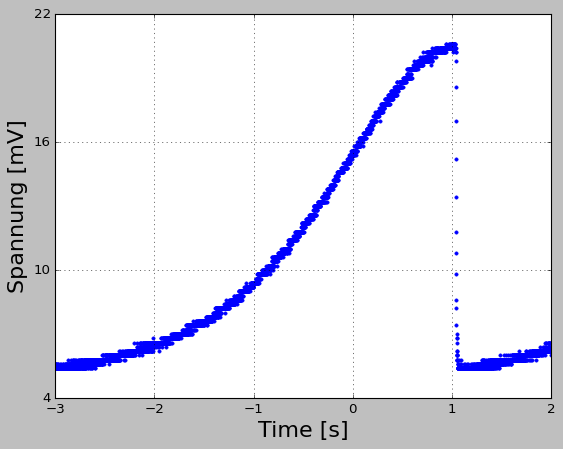

In [ ]:
plt.plot(x,y,'.')
plt.xlabel('Time [s]',fontsize=20)
plt.ylabel('Spannung [mV]',fontsize=20)
plt.yticks([4,10,16,22])
plt.grid()
plt.savefig('A2-Oszi.png',dpi=600,transparent=True)

### Test

In [ ]:
print(max(y),y.argmax())
print(min(y),y.argmin())

20.6 5380
5.4 0


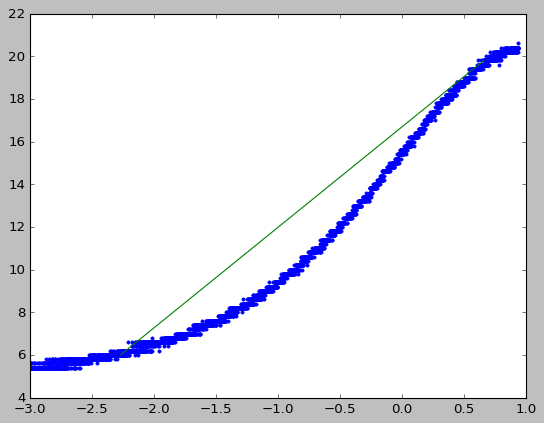

In [ ]:
x1 = x[:5382]
y1 = y[:5382]
plt.plot(x1,y1,'.')
plt.plot([x1[1000],x1[5000]],[y1[1000],y1[5000]])

## Task 3

Report Task: Describe what you have done and explain why we have to
use a lens even though the light is collimated.

In [ ]:
o1 = 38.5 * u.centimeter
o2 = 48.5 * u.centimeter
u_o1 = 0.04*o1
u_o2 = 0.04*o2
print(f'{o1} +/- {round(u_o1,1)}')
print(f'{o2} +/- {round(u_o2,1)}')

38.5 centimeter +/- 1.5 centimeter
48.5 centimeter +/- 1.9 centimeter


In [ ]:
bw1 = bildweite(o1)
bw2 = bildweite(o2)
ubw1 = u_bw(o1,u_o1)
ubw2 = u_bw(o2,u_o2)

print(f'Erste Bildweite: {round(bw1,1)} +/- {round(ubw1,1)}')
print(f'Erste Bildweite: {round(bw2,1)} +/- {round(ubw2,1)}')

Erste Bildweite: 41.6 centimeter +/- 1.8 centimeter
Erste Bildweite: 34.0 centimeter +/- 1.0 centimeter


## Task 5

In [ ]:
!wget 'https://github.com/Ben-physics-dotcom/Internships/blob/main/FPR-1/Fourier-Optics/Data/exp_spatial_filtering.png'
p_filt = '/content/exp_spatial_filtering.png'

### Report Task

Report Task:

- Fourier transform the sample images using your favorite analysis software
(Python, Matlab, Mathematica...) and compare to the optical
Fourier transforms that you saved with the camera (the functions are
called fft2 and fftshift). Describe any differences you can see. Visualize
also the phase and magnitude of the Fourier transforms.

In [ ]:
p3 = '/content/3.bmp'
pf = '/content/F.bmp'
p_hu = '/content/HU Logo.bmp'

#### Correct Fourier Transformation

In this chapter is the correct code to make a fourier transform on bmp file. Don't try to make a fourier transform on a bmp file with reading the file with plt.imread. It won't work. For that see the next three chapters.

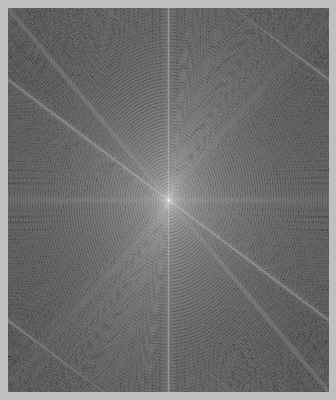

In [ ]:
pp3 = load_image(p3)
res3 = apply_fft(pp3)
plt.axis('off')
plt.imshow(res3, cmap='gray')
plt.savefig('Res_3.png',dpi=600,transparent=True)

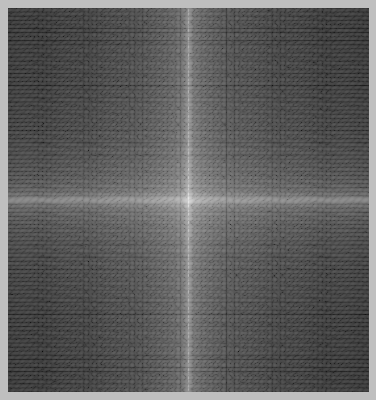

In [ ]:
F = load_image(pf)
plt.axis('off')
resF = apply_fft(F)
plt.imshow(resF, cmap='gray')
plt.savefig('F_res.png',dpi=600,transparent=True)

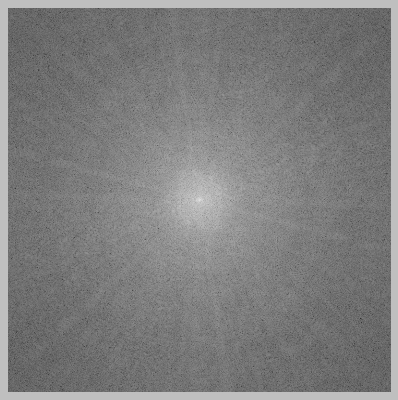

In [ ]:
test = load_image(p_hu)
res = apply_fft(test)
plt.axis('off')
plt.imshow(res, cmap='gray')
plt.savefig('HU_LOGO.png',dpi=600,transparent=True)

#### 3 image

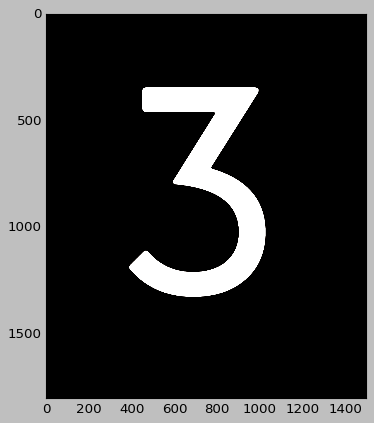

In [ ]:
p3 = plt.imread(p3)
plt.imshow(p3)

In [ ]:
ft_p3 = calc_2ddft(p3)
ft_p3[0]

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

In [ ]:
len(ft_p3)

1800

<ipython-input-39-9df547bcfdd6>:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(ft_p3.real),cmap='gray')
<ipython-input-39-9df547bcfdd6>:1: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(ft_p3.real),cmap='gray')
/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


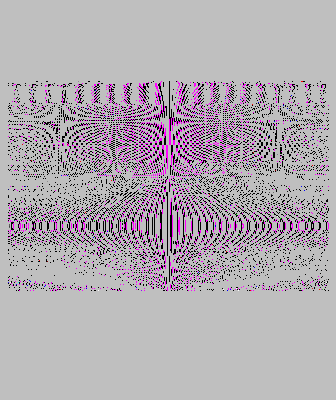

In [ ]:
plt.imshow(np.log(ft_p3.real),cmap='gray')
plt.axis('off')
plt.savefig('3_real_plt_imread.png',dpi=600,transparent=True)

<ipython-input-40-2d648c3d97e4>:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(ft_p3.imag),cmap='gray')
<ipython-input-40-2d648c3d97e4>:1: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(ft_p3.imag),cmap='gray')


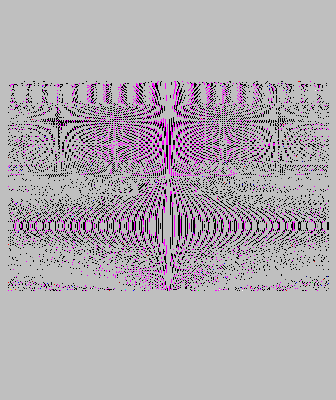

In [ ]:
plt.imshow(np.log(ft_p3.imag),cmap='gray')
plt.axis('off')
plt.savefig('3_imag_plt_imag.png',dpi=600,transparent=True)

##### Test

<ipython-input-41-6008f9cff465>:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(abs(t)),cmap='gray')


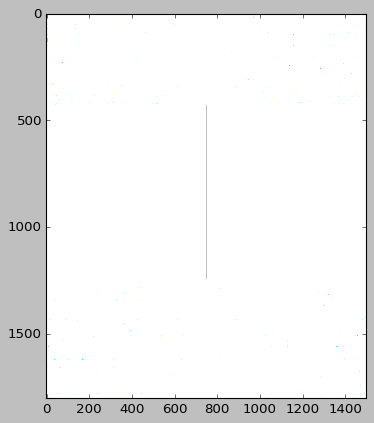

In [ ]:
t = fftshift(fft2(p3))
plt.imshow(np.log(abs(t)),cmap='gray')

In [ ]:
# t3 = abs(ft1(fftshift(p3)))

In [ ]:
# plt.imshow(t3)

#### F image

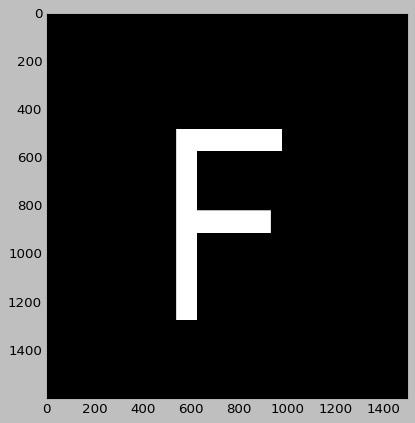

In [ ]:
pf = plt.imread(pf)
plt.imshow(pf)

In [ ]:
ft_pf = calc_2ddft(pf)

<ipython-input-46-7fcdf6b17047>:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(ft_pf)),cmap='gray')


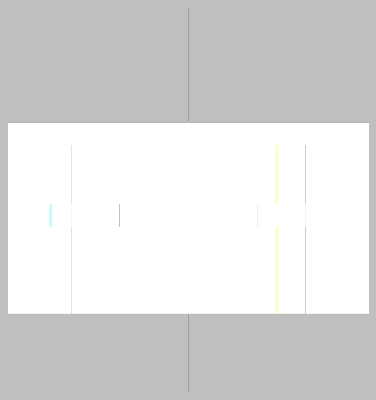

In [ ]:
plt.imshow(np.log(np.abs(ft_pf)),cmap='gray')
plt.axis('off')
plt.savefig('t_F.png',dpi=600,transparent=True)

##### Test

In [ ]:
# tf  = fftshift(fft2(pf))
# plt.plot(abs(tf))

#### hu berlin

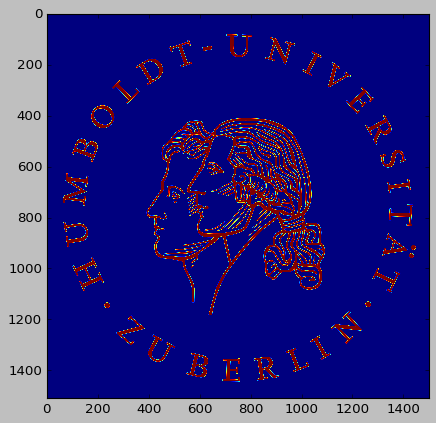

In [ ]:
p_hu = plt.imread(p_hu)
# p_hu = p_hu[:, :3].mean(axis=2)
plt.imshow(p_hu)

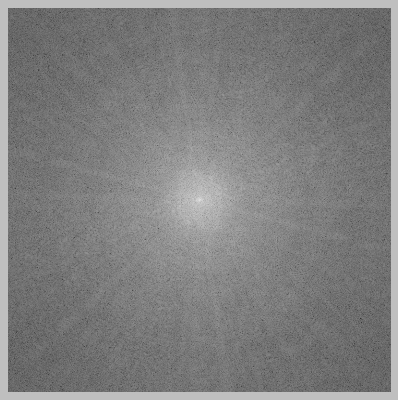

In [ ]:
ft_hu = calc_2ddft(p_hu)
plt.imshow(np.log(abs(ft_hu)),cmap='gray')
plt.axis('off')
plt.savefig('hu_logo_plt_imread.png',dpi=600,transparent=True)

### bmp into png

In [ ]:
lst = ['/content/3.bmp','/content/F.bmp','/content/HU Logo.bmp']
lst1 = ['3.png','F.png','hu_log.png']
for i in range(3):
  img = Image.open(lst[i])
  new_img = img.resize( (256, 256) )
  new_img.save( lst1[i], 'png')

## Task 7

Report Task: Implement spatial filtering with different kind of filters in
software (FFT and IFFT plus a mask) and compare the results to the images
that we generated optically. Discuss any differences.

### Data

In [ ]:
files = [
    '/content/4fsetup,ohne2.jpg',
    '/content/4fsetup,radius =10, circular, high pass2.jpg',
    '/content/4fsetup,radius =50, circular, high pass1.jpg',
    '/content/4fsetup,radius =50, circular, high pass2.jpg',
    '/content/4fsetup,slidt wide=30, horizontal, high pass2.jpg',
    '/content/4fsetup,slidt wide=30, horizontal, low pass2.jpg',
    '/content/4fsetup,slidt wide=30, vertical, high pass2.jpg',
    '/content/4fsetup,slidt wide=30, vertical, low pass1.jpg',
    '/content/4fsetup,slidt wide=30, vertical, low pass2.jpg'
]

### Test 1

In [ ]:
# Example usage:
# Create an instance of ImageFileManager
image_file_manager = ImageFileManager(files)

# Example usage
mask_type = 'circular'
pass_type = 'high'
size = 10
#mask_type, pass_type, size

file_name = image_file_manager.extract_file(mask_type, pass_type, size)
if file_name:
    print(f"File corresponding to mask type '{mask_type}', pass type '{pass_type}', and size '{size}' is: {file_name}")
else:
    print("File not found.")


File corresponding to mask type 'circular', pass type 'high', and size '10' is: /content/4fsetup,radius =10, circular, high pass2.jpg


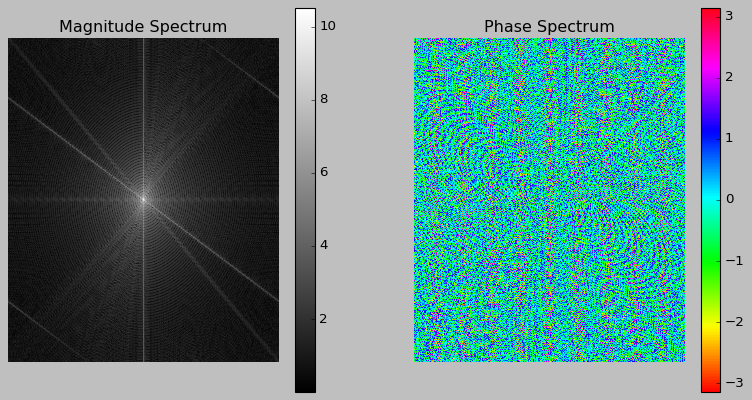

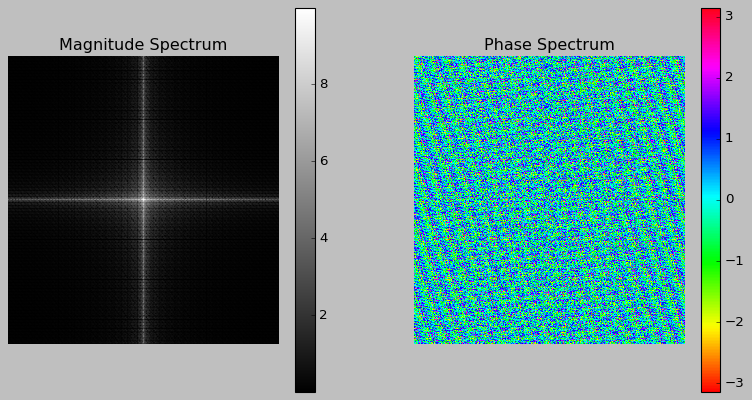

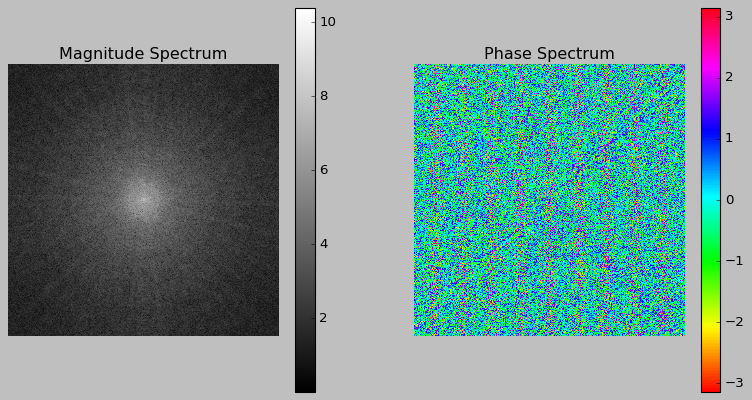

In [ ]:
imag = ['/content/3.bmp','/content/F.bmp','/content/HU Logo.bmp']
image_processors = [ImageProcessor(file) for file in imag]

for image_processor in image_processors:
    #image_processor.display_org_mag()
    image_processor.display_mag_phase()

/content/4fsetup,radius =10, circular, high pass2.jpg


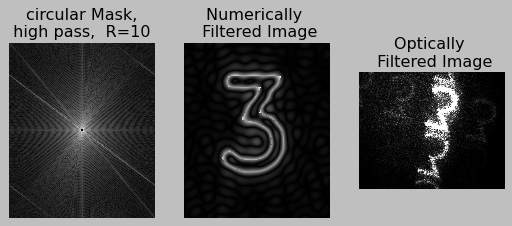

In [ ]:
# # Example usage
image_file = '3.bmp'
image_processor = ImageProcessor(image_file)

# # no mask
# filtered_image = ip.apply_spatial_filter(mask_type= 'circular', radius=10, pass_type='high pass')

# # circular
image_processor.apply_spatial_filter(mask_type='circular', pass_type='high',
                                     radius=10)
plt.savefig('3_circ_high_r=10.png',dpi=600,transparent=True)


/content/4fsetup,radius =50, circular, high pass1.jpg


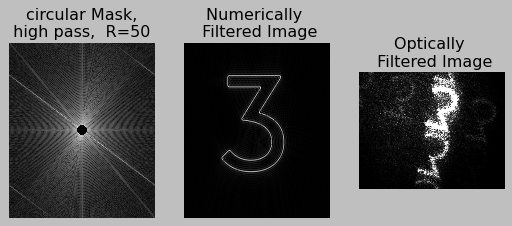

In [ ]:
image_processor.apply_spatial_filter(mask_type='circular', pass_type='high',
                                     radius=50)
plt.savefig('3_circ_high_r=50.png',dpi=600,transparent=True)

/content/4fsetup,slidt wide=30, horizontal, high pass2.jpg


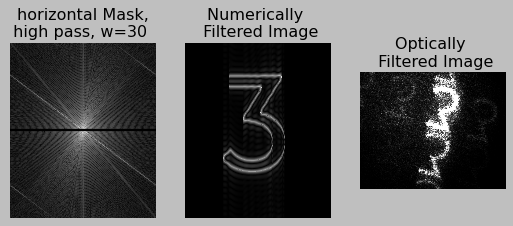

In [ ]:
image_processor.apply_spatial_filter(mask_type='horizontal', pass_type='high',
                                     width=30)
plt.savefig('3_hor_high_r=30.png',dpi=600,transparent=True)

/content/4fsetup,slidt wide=30, horizontal, low pass2.jpg


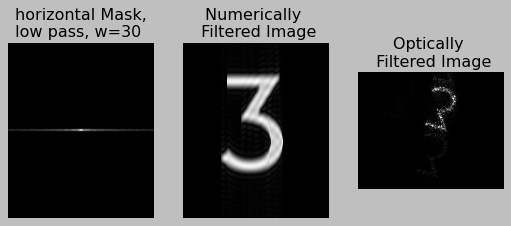

In [ ]:
image_processor.apply_spatial_filter(mask_type='horizontal', pass_type='low',
                                     width=30)
plt.savefig('3_hor_low_r=30.png',dpi=600,transparent=True)

/content/4fsetup,slidt wide=30, vertical, high pass2.jpg


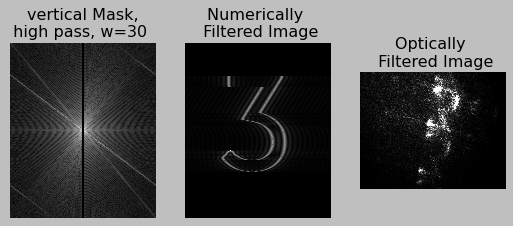

In [ ]:
image_processor.apply_spatial_filter(mask_type='vertical', pass_type='high',
                                     width=30)
plt.savefig('3_vert_high_r=30.png',dpi=600,transparent=True)

/content/4fsetup,slidt wide=30, vertical, low pass1.jpg


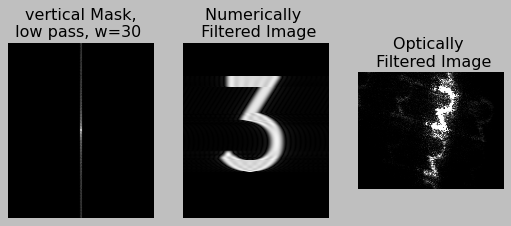

In [ ]:
image_processor.apply_spatial_filter(mask_type='vertical', pass_type='low',
                                     width=30)
plt.savefig('3_vert_low_r=30.png',dpi=600,transparent=True)

### Test

In [ ]:

# Perform FFT
def fft_image(image_array):
    return np.fft.fftshift(np.fft.fft2(image_array))

# Apply a mask (filter) in the frequency domain
def apply_filter(fft_image, mask):
    return fft_image * mask

# Perform IFFT
def ifft_image(filtered_fft):
    return np.abs(np.fft.ifft2(np.fft.ifftshift(filtered_fft)))

# Generate different masks
def generate_circular_mask(shape, radius, value=1):
    rows, cols = shape
    center = (rows // 2, cols // 2)
    y, x = np.ogrid[:rows, :cols]
    mask = np.zeros(shape)
    mask_area = (x - center[1])**2 + (y - center[0])**2 <= radius**2
    mask[mask_area] = value
    return mask

def generate_high_pass_mask(shape, radius):
    return 1 - generate_circular_mask(shape, radius)
# Generate a low-pass filter mask
def generate_low_pass_mask(shape, radius):
    return generate_circular_mask(shape, radius)

# Visualize the results
def visualize_results(original_image, masks, filtered_images):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, len(masks) + 1, 1)
    plt.title("Original Image")
    plt.imshow(original_image, cmap='gray')
    plt.axis('off')

    for i, (mask, filtered_image) in enumerate(zip(masks, filtered_images)):
        plt.subplot(2, len(masks) + 1, i + 2)
        plt.title(f"Mask {i+1}")
        plt.imshow(mask, cmap='gray')
        plt.axis('off')

        plt.subplot(2, len(masks) + 1, i + len(masks) + 3)
        plt.title(f"Filtered {i+1}")
        plt.imshow(filtered_image, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Generate a vertical filter mask
def generate_vertical_mask(shape):
    rows, cols = shape
    mask = np.zeros(shape)
    center_col = cols // 2
    mask[:, center_col-10:center_col+10] = 1  # Adjust the width as necessary
    return mask

# Generate a horizontal filter mask
def generate_horizontal_mask(shape):
    rows, cols = shape
    mask = np.zeros(shape)
    center_row = rows // 2
    mask[center_row-10:center_row+10, :] = 1  # Adjust the height as necessary
    return mask


# def main(ip):
#     image_path = ip  # Replace with your BMP image path
#     image = load_image(image_path)
#     fft_img = fft_image(image)

#     # Create different masks
#     mask1 = generate_circular_mask(image.shape, radius=30)  # Low-pass filter
#     mask2 = generate_high_pass_mask(image.shape, radius=30)  # High-pass filter

#     masks = [mask1, mask2]

#     filtered_images = []
#     for mask in masks:
#         filtered_fft = apply_filter(fft_img, mask)
#         filtered_image = ifft_image(filtered_fft)
#         filtered_images.append(filtered_image)

#     visualize_results(image, masks, filtered_images)

# if __name__ == "__main__":
#     main(ip)


## Task 8

Report Task:

- Implement your own Gerchberg-Saxton algorithm (see Wikipedia for an
easy pseudo code implementation) and estimate the error reduction for
each subsequent iteration of the algorithm.
- Describe differences between your recorded images and the ones you get
from inverse transforming the phase you get from the Gerchberg-Saxton

Pseudo-Code from Wikipedia (Key: Wikipedia.2024)

Let:


 FT – forward Fourier transform


 IFT – inverse Fourier transform


 i – the imaginary unit, √−1 (square root of −1)


 exp – exponential function (exp(x) = ex)

 Target and Source be the Target and Source Amplitude planes respectively
 A, B, C & D be complex planes with the same dimension as Target and Source
 Amplitude – Amplitude-extracting function:

  e.g. for complex z = x + iy, amplitude(z) = sqrt(x·x + y·y)
       for real x, amplitude(x) = |x|

 Phase – Phase extracting function:

   e.g. Phase(z) = arctan(y / x)

end Let

algorithm Gerchberg–Saxton(Source, Target, Retrieved_Phase) is

    A := IFT(Target)
    while error criterion is not satisfied
        B := Amplitude(Source) × exp(i × Phase(A))
        C := FT(B)
        D := Amplitude(Target) × exp(i × Phase(C))
        A := IFT(D)
    end while
    Retrieved_Phase = Phase(A)



from [GitHub](https://github.com/wxwang0104/Phase_retrieval_single_constraint/blob/master/phase_retrieval_GS.py)

In [ ]:
class PhaseRetrievalProcessor:
    def __init__(self, file):
        self.image_array = self.image_to_array(file)
        self.f_transform, self.magnitude_spectrum, self.phase_spectrum = self.fouriertrans()
        self.gaussian_amplitude = self.generate_gaussian_amplitude()

    def image_to_array(self,file):
        # Load the image
        image = Image.open(file)
        # Convert the image to grayscale
        image_gray = image.convert('L')
        # Convert the image to a numpy array
        image_array = np.array(image_gray)
        return image_array

    def fouriertrans(self):
        # Perform the 2D Fourier transform
        f_transform = fftshift(fft2(self.image_array, norm='ortho'))
        # Separate the complex Fourier transform into magnitude and phase components
        magnitude_spectrum = np.abs(f_transform)
        phase_spectrum = np.angle(f_transform)
        return f_transform, magnitude_spectrum, phase_spectrum

    def generate_gaussian_amplitude(self):
        # Calculate a Gaussian amplitude profile based on the image dimensions
        rows, cols = self.image_array.shape
        x = np.linspace(-cols//2, cols//2, cols)
        y = np.linspace(-rows//2, rows//2, rows)
        X, Y = np.meshgrid(x, y)
        sigma = min(cols, rows) / 4  # Standard deviation for Gaussian
        gaussian_amplitude = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
        return gaussian_amplitude


    def gerchberg_saxton(self, max_iterations=100, error_threshold=1e-6):
        A = ifft2(self.image_array)
        errors = []  # List to store error values for each iteration

        for i in range(max_iterations):
            B = np.abs(self.gaussian_amplitude) * np.exp(1j * np.angle(A))
            C = fft2(B)
            D = np.abs(self.image_array) * np.exp(1j * np.angle(C))
            A_new = ifft2(D)

            error = np.mean(np.abs(np.angle(A_new) - np.angle(A)))
            errors.append(error)  # Store error for this iteration

            if error < error_threshold:
                break

            A = A_new
            # print(i)

        return np.angle(A), errors

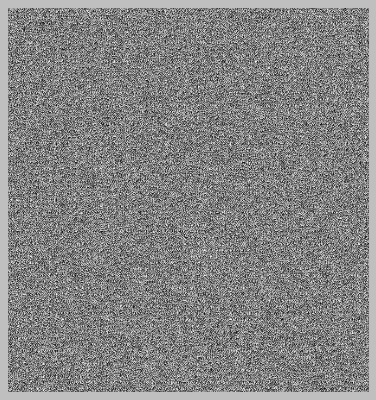

In [ ]:
# Create an instance of ImageProcessor
processor = PhaseRetrievalProcessor('F.bmp')

# Run Gerchberg-Saxton algorithm
retrieved_phase, errors = processor.gerchberg_saxton(max_iterations=15)

# Display the retrieved phase spectrum
plt.imshow(retrieved_phase, cmap='gray')
# plt.title('Retrieved Phase Spectrum')
plt.axis('off')
plt.savefig('Retrieved Phase Spectrum.pdf',dpi=600,transparent=True)
# plt.show()


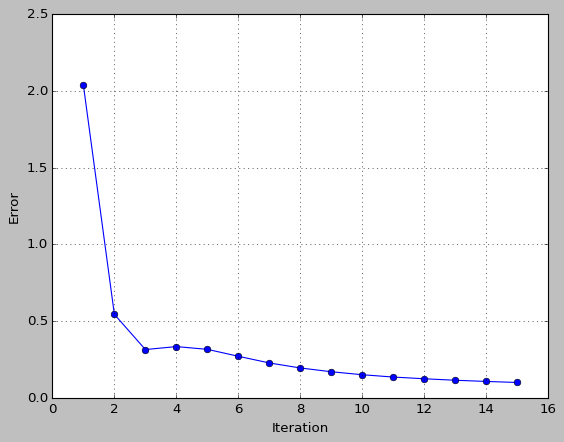

In [ ]:
# Plot the error reduction for each iteration
plt.plot(range(1, len(errors) + 1), errors, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Error')
# plt.title('Error Reduction in Gerchberg-Saxton Algorithm')
plt.grid(True)
plt.savefig('error Reduction in gsa.pdf',dpi=600,transparent=True)

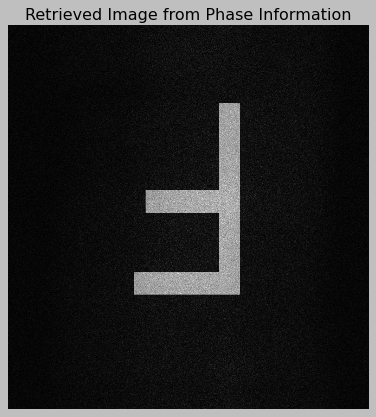

In [ ]:
# Assuming Gaussian source amplitude as in the initialization of the Gerchberg-Saxton
gaussian_amplitude = processor.generate_gaussian_amplitude()

# Compute the retrieved image from the retrieved phase information
retrieved_image = np.abs(ifft2(gaussian_amplitude * np.exp(1j * retrieved_phase)))

# Display the retrieved image
plt.imshow(retrieved_image, cmap='gray')
plt.title('Retrieved Image from Phase Information')
plt.axis('off')
plt.savefig('Retrieved Image from Phase Information.pdf',dpi=600,transparent=True)
# plt.show()